### Data processing

Data & imports

In [1]:
import pandas as pd
import create_dataset as cd
import feature_engineering as fe
import os 
from prep import * 

In [2]:
data_tim = pd.read_csv('datasets/raw_data_tim_copy.csv')
data_sien = pd.read_csv('datasets/raw_data_sien_copy.csv')
data_tim2 = pd.read_csv('datasets/raw_data_tim_2_copy.csv')
data_sien2 = pd.read_csv('datasets/raw_data_sien_2_copy.csv')

Create_dataset.py

In [3]:
# combine tim & sien dfs 
data = cd.combine_start_dfs(data_sien, data_sien2, data_tim, data_tim2)
# change name climber to numerical value
data['name_climber'] = data['name_climber'].map({'sien':0,'tim':1})
# drop weird column (SIEN's FAULT)
data = data.drop(columns = ['Time (s).1'])
# drop climber rating var 
data = cd.drop_climber_rating(data)
# add datetime var 
data = cd.add_datetime(data) # odd missalignment when viewing data in dataviewer 
# add heart-rate var
# TODO:  make sure to check with times and time zone thing idk 
# cut falls 
data = cd.cut_fall(data)

In [4]:
data.head()

,entry_num,datetime,Time (s),X (m/s^2),Y (m/s^2),Z (m/s^2),X (rad/s),Y (rad/s),Z (rad/s),name_climber,grading,num_attempt,fall_top
0,15,2023-06-07 16:36:31.299000+02:00,0.202257,0.616807,0.545096,-0.119170,-0.738735,-0.693665,-0.053444,0,4c,1,0
1,15,2023-06-07 16:36:31.500717138+02:00,0.403552,0.427085,-0.449999,0.075464,-0.314339,-0.378076,0.015612,0,4c,1,0
2,15,2023-06-07 16:36:31.702434276+02:00,0.604846,0.570240,0.152899,-0.213106,-0.273812,-0.442562,-0.130227,0,4c,1,0
3,15,2023-06-07 16:36:31.904151414+02:00,0.806141,0.295633,-0.453686,0.244799,-0.260747,-0.114135,-0.019194,0,4c,1,0
4,15,2023-06-07 16:36:32.105868552+02:00,1.007435,0.206272,-0.927811,-0.512616,-0.160211,-0.226173,-0.211577,0,4c,1,0


feature_engineering.py

In [5]:
data = fe.features(data)
data.grading = data.grading.apply(fe.french_grade_to_num)

prep.py

In [6]:
data = create_snippets(data, 20, 5)
print(data.groupby("entry_num").size())
data = change_climb_ID(data)

# show number of rows per climb_id
# save data
data.to_csv('datasets/processed_data.csv', index = False)


data = aggregate_rf(data)

data.head()

entry_num
1     201
2     201
3     201
4     201
5     185
6     201
7     201
8     201
9     201
10    192
11    201
12    201
13    201
14    201
15    201
16    201
17    201
18    201
19    201
20    201
21    201
22    201
23    201
24    201
25    201
dtype: int64


/Users/ryonamba/Documents/VU/VU-master_year_1/ML_quantified_self/ML4QS/prep.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_20sec.loc[:, "snippet"] = "random_snippet"
/Users/ryonamba/Documents/VU/VU-master_year_1/ML_quantified_self/ML4QS/prep.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  random_20sec.loc[:, "fall_top"] = 0
/Users/ryonamba/Documents/VU/VU-master_year_1/ML_quantified_self/ML4QS/prep.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

IndexError: Cannot choose from an empty sequence

In [ ]:
data = data.drop(columns = ['datetime'])

Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image

model_data = data.copy(deep=True)

x = model_data.drop('fall_top', axis=1)
y = model_data['fall_top']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

mod = RandomForestClassifier(random_state= 42)
mod.fit(X_train, Y_train)

Y_pred = mod.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, zero_division=0)
recall = recall_score(Y_test, Y_pred, zero_division=0)
f1 = f1_score(Y_test, Y_pred, zero_division=0)

print("accuracy:", accuracy, " precision:", precision, "precision:", recall, "f1:", f1)

cm = confusion_matrix(Y_test, Y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

ValueError: Unknown label type: 'unknown'

In [ ]:
param_dist = {'n_estimators': randint(50,1500),
            'max_depth': randint(1,30)}
    
mod = RandomForestClassifier(random_state= 42)

rand_search = RandomizedSearchCV(mod, param_distributions = param_dist, n_iter=5, cv=3)

rand_search.fit(X_train, Y_train)

best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 24, 'n_estimators': 407}


accuracy: 0.9  precision: 0.5 precision: 1.0 f1: 0.6666666666666666


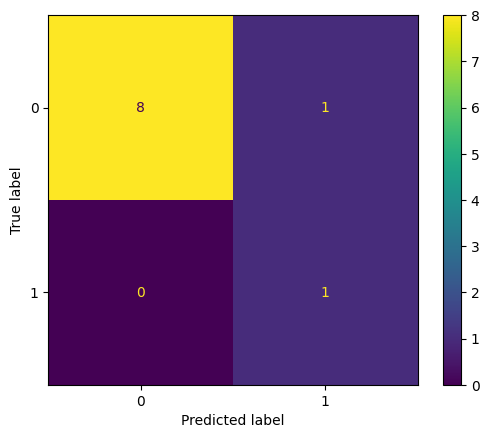

In [ ]:
Y_pred_best = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()


accuracy = accuracy_score(Y_test, Y_pred_best)
precision = precision_score(Y_test, Y_pred_best, zero_division=0)
recall = recall_score(Y_test, Y_pred_best, zero_division=0)
f1 = f1_score(Y_test, Y_pred_best, zero_division=0)

print("accuracy:", accuracy, " precision:", precision, "precision:", recall, "f1:", f1)